Autoencoders

In [1]:
import cv2
import os
import numpy as np
from tensorflow import keras

# Function to load all video data from a directory
def load_videos_from_directory(directory, max_frames=100):
    video_data = []
    
    # List all files in the directory
    files = os.listdir(directory)
    
    for file in files:
        if file.endswith(".mp4"):
            video_path = os.path.join(directory, file)
            frames = load_video(video_path, max_frames)
            video_data.append(frames)
    
    return video_data

def load_video(file_path, max_frames=100, frame_shape=(64, 64)):
    cap = cv2.VideoCapture(file_path)
    frames = []
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, frame_shape)
        frame = np.expand_dims(frame, axis=-1)
        frames.append(frame / 255.0)
        frame_count += 1
    
    cap.release()
    # Pad or truncate frames to max_frames
    frames = frames + [np.zeros_like(frames[0])] * (max_frames - len(frames))
    return np.array(frames)

# Specify the directories 
brushing_directory = "/Users/sudachk/PacktPublishing/DataLabelling/ch09/Kinetics/autoencode/brushing"
dancing_directory = "/Users/sudachk/PacktPublishing/DataLabelling/ch09/Kinetics/autoencode/dance"

# Load video data for "brushing"
brushing_data = load_videos_from_directory(brushing_directory)

# Load video data for "dancing"
dancing_data = load_videos_from_directory(dancing_directory)

# Find the minimum number of frames among all videos
min_frames = min(min(len(video) for video in brushing_data), min(len(video) for video in dancing_data))

# Ensure all videos have the same number of frames
brushing_data = [video[:min_frames] for video in brushing_data]
dancing_data = [video[:min_frames] for video in dancing_data]
# Combine the videos into a single dataset
#video_data = np.concatenate([brushing_data, dancing_data])

# Split the data into training and testing sets
#train_data = video_data[0]  # Remove the outer list
#test_data = video_data[1]

# Define the input shape based on the actual dimensions of the loaded video frames
#input_shape = train_data.shape[1:]
#print("Input shape:", input_shape)

# Separate the brushing and dancing data for training
#brushing_train = np.expand_dims(brushing_data[0], axis=0)
#dancing_train = np.expand_dims(dancing_data[0], axis=0)

# Reshape the data to have the correct input shape
#brushing_train = brushing_train.reshape((-1,) + input_shape)
#dancing_train = dancing_train.reshape((-1,) + input_shape)


# Reshape the data to have the correct input shape 
# Selecting the first instance from brushing_data for training and dancing_data for testing
train_data = brushing_data[0]
test_data = dancing_data[0]

# Define the input shape based on the actual dimensions of the loaded video frames
input_shape= train_data.shape[1:]

print("Input shape:", input_shape)




# Define the encoder part of the autoencoder
# ... (rest of the model definition remains the same)


# Define the encoder part of the autoencoder
encoder_input = keras.Input(shape=input_shape)
encoder = keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding="same")(encoder_input)
encoder = keras.layers.MaxPooling2D(pool_size=2)(encoder)
encoder = keras.layers.Conv2D(filters=8, kernel_size=3, activation="relu", padding="same")(encoder)
encoder = keras.layers.MaxPooling2D(pool_size=2)(encoder)

# Define the decoder part of the autoencoder
decoder = keras.layers.Conv2D(filters=8, kernel_size=3, activation="relu", padding="same")(encoder)
decoder = keras.layers.UpSampling2D(size=2)(decoder)
decoder = keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding="same")(decoder)
decoder = keras.layers.UpSampling2D(size=2)(decoder)

# Modify the last layer to have 1 filter (matching the number of channels in the input)
decoder_output = keras.layers.Conv2D(filters=1, kernel_size=3, activation="sigmoid", padding="same")(decoder)

# Create the autoencoder model
autoencoder = keras.Model(encoder_input, decoder_output)
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")


# Train the model
autoencoder.fit(train_data, train_data, epochs=10, batch_size=32, validation_data=(test_data, test_data))


# Save the trained autoencoder model to a file
autoencoder.save('autoencoder_model.keras')

# Generate predictions on testing data
decoded_frames = autoencoder.predict(test_data)

# Evaluate the model
loss = autoencoder.evaluate(decoded_frames, test_data)
print("Reconstruction loss:", loss)


Input shape: (64, 64, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 

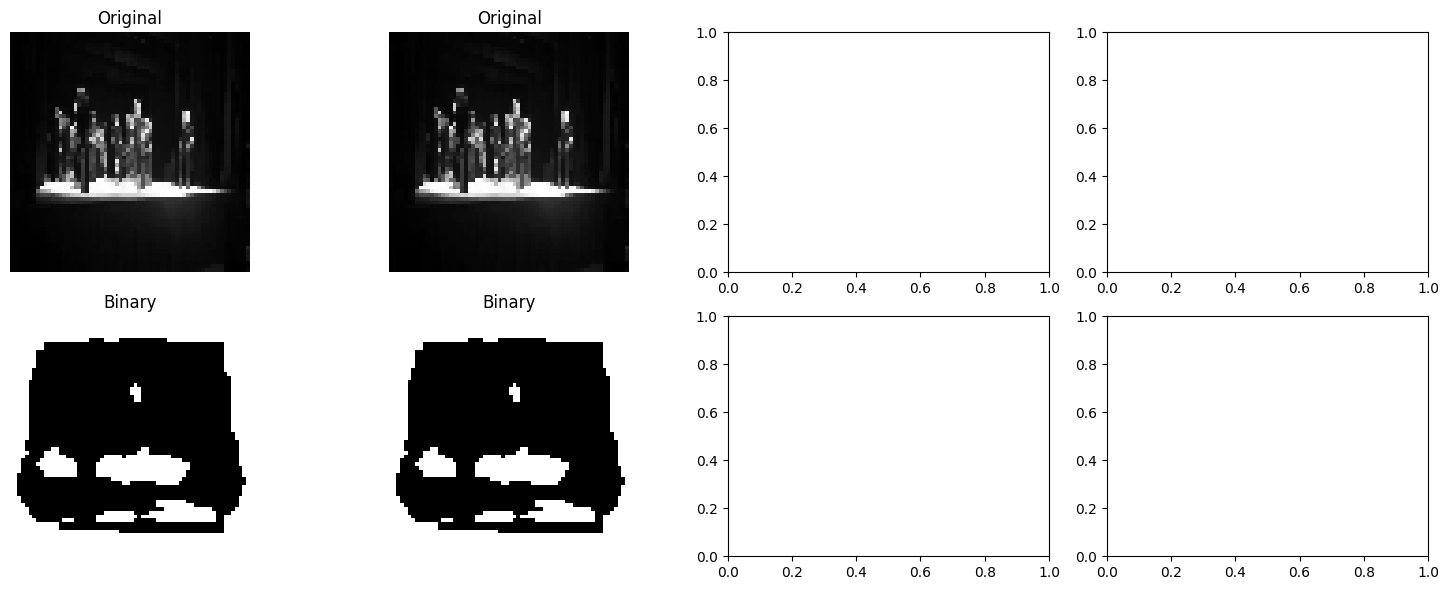

In [28]:
import matplotlib.pyplot as plt

# Apply thresholding
threshold = 0.20
binary_frames = (decoded_frames > threshold).astype('uint8')

# Visualize 2 original frames and 2 binary frames
fig, axes = plt.subplots(2, 4, figsize=(15, 6))  # Increase figsize width

for i in range(2):
    axes[0, i].imshow(test_data[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    axes[1, i].imshow(binary_frames[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Binary")

plt.tight_layout()
plt.show()
